# Exercise 2: Interactive Segmentation

Your tic-tac-toe championship was a major success and everyone is waiting for the next event from you.
Meanwhile, some curious eyes have also noticed the impressive compression algorithm you developed.
Among them is a group of budding entrepreneurs who are working on a noble mission: to empower everyone to make their own *Cat Memes*.
Specifically, they are developing an app where you can take a photo of your cute cat, segment it out, and paste it on any background to design your own meme.
Crucially, the users only have to create a few scribbles, which mark the foreground (the cat) and background of the image.
As none of the founders are Computer Vision engineers, they have approached you to develop the segmentation algorithm for the app.
An overview of the desired pipeline is shown below.

</br>
</br>

![](https://drive.google.com/uc?export=view&id=1AyQIlnBRmQjbHquCQVDYdCO4m9UCLDqX)

</br>
</br>

**Details about the setup**
* For each test sample, the algorithm is provided a triplet consisting of the RGB image, the foreground (FG) scribble and the background (BG) scribble.
We denote this triplet as a *sample*.
* FG scribble is a grayscale image, where white pixels (255) are guaranteed to belong to the foreground (cat).
* BG scribble is a grayscale image, where white pixels (255) are guaranteed to belong to the background.
* The RGB image is a discrete image of 3 channels. Each pixel in these images is an integer which can take values between [0, 255]
* All images of a sample have the same size. However, note that RGB images from two different samples may have different sizes.

Given an input sample, your algorithm should output a single channel segmentation mask, of the same height and width as the input images.
The output should be a boolean NumPy array (dtype `bool`) with values `True` for the foreground (cat) and value `False` for the background regions.
In order to design your segmentation algorithm, we provide a validation dataset of 10 samples including ground truth segmentations.
</br>


**Evaluation Criteria**

Your algorithm will be evaluated using the Intersection-over-Union (IoU) metric.
Given the ground truth mask $A$ and the predicted mask $B$ for a sample, the metric computes (for exact details check the function `compute_iou()` inside `utils.py`)

$$
\text{IoU} = \frac{A \cap B}{A \cup B}
$$

If you follow the suggested approach, the final algorithm will be stochastic.
To report a trustworthy score, the evaluation will be run multiple times with different random seeds. The final score is obtained as average IoU over all test images and all random seeds.


**Passing requirement**

Your algorithm will be evaluated using an online evaluation server on a hidden test set.
In order to pass the exercise, you need to obtain an EvaluationScore of **greater than $0.59$** on the test set.
Additionally, your segmentation algorithm should be reasonably fast, that is, segment each sample in less than 5 seconds.
Otherwise your score will automatically be set to 0.
The ranking on the leaderboard is obtained using only the EvaluationScore.

Follow the steps in the rest of the notebook to generate the submission.

In [1]:
# These two lines ensure that we always import the latest version of a package, in case it has been modified.
%load_ext autoreload
%autoreload 2

import sys
import shutil
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Mount your drive and set the correct path
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**TODO:** Set the path in Google drive where you uploaded the handout, e.g. MyDrive/iacv/ex2 </br>
**NOTE:** Even if your drive is set to a different language - always start the path with MyDrive

In [3]:
# TODO
iacv_path = 'MyDrive/iacv-exercises/ex2/handout/'

env_path = Path('/content/drive') / iacv_path
data_path = env_path / 'data'

# Add the handout folder to python paths
if str(env_path) not in sys.path:
    sys.path.append(str(env_path))

# Now we can import our other files
from utils import (
    compute_iou,
    evaluate_segmentation,
    load_sample,
    show_sample
)

from image_segmenter import ImageSegmenter

## Visualise random sample

In [4]:
# Go through 'val' folder and get names of subdirectories - one subdir is one sample
sample_dirs = [dd for dd in data_path.iterdir() if dd.is_dir()]

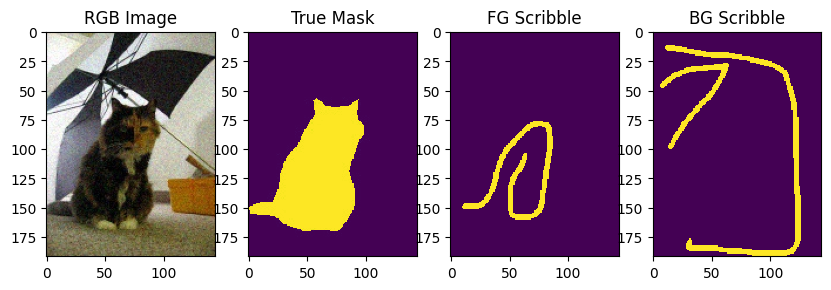

In [5]:
sample_path = data_path / '04'
sample_dd = load_sample(sample_path)
show_sample(sample_dd, show_scribble=True)

## Implement your solution

You are provided with a simple implementation of the `ImageSegmenter` class (`image_segmenter.py`).
The `ImageSegmenter` class is responsible to generate a segmentation mask, given a sample.
Modify this class to include your algorithm.

The rest of the exercise will roughly explain how the baseline solution was implemented.
If you follow the descriptions, implement the missing bits and tune some hyperparameters you will have no problem passing this exercise.

**Notes:**

* Having said that, you are free to implement whichever algorithm you fancy - as long as you do not use external packages and beat the baseline, anything is allowed.
* You are not allowed to use any external packages except the ones already imported in `image_segmenter.py`. Otherwise your submission will crash on the Evaluation server.
* You might want to first check out how the `ImageSegmenter` class will be used, before implementing.
Have a look at the code below

### K-means clustering and KNN classification

The FG/BG scribble masks provide us with locations in the image, which correspond to foreground/background respectively.
We can use these masks to perform segmentation as follows:
1. In a first step we extract all pixels intensities of foreground only.
We can then use a clustering algorithm, such as k-means, to create $k_1$ visual words, which "summarise" these foreground pixels.
2. The same can be done for background pixels using $k_2$ clusters.
3. With k-means we have now extracted two sets of cluster centroids: The first $k_1$ centroids represent a model of foreground pixels, while the other $k_2$ centroids correspond to background pixels.
4. We can now predict the label of any other pixel in the image using nearest neighbor classification: If the closest of all $k_1 + k_2$ centroids came from the foreground clusters, the pixel is labeled foreground - otherwise background.

What you have to do:
* Implement the k-means clustering algorithm.
The file `kmeans.py` provides a starting point.
* Implement the kNN classifier (no need to cover k > 1). Again the file `kmeans.py` provides a starting point.
* Implement the method `segment_image_kmeans()` of the `ImageSegmenter` class. Here you have to combine the two algorithms in order to segment FG/BG with the strategy outlined above.

The following image shows a segmentation, that has been created with this approach.
Note how the prediction is noisy and dark parts of the background are often mistaken to be foreground.

</br>

![](https://drive.google.com/uc?export=view&id=15hG1Atv_En0A0df0QTRU3i1P4dqRcoP9)

In [ ]:
# This code tests your k-means implementation
from kmeans import kmeans_fit, check_kmeans

check_kmeans(kmeans_fit, data_path)

In [ ]:
# This code tests your kNN implementation
from kmeans import kNN, check_kNN

check_kNN(kNN, display_prediction=True)

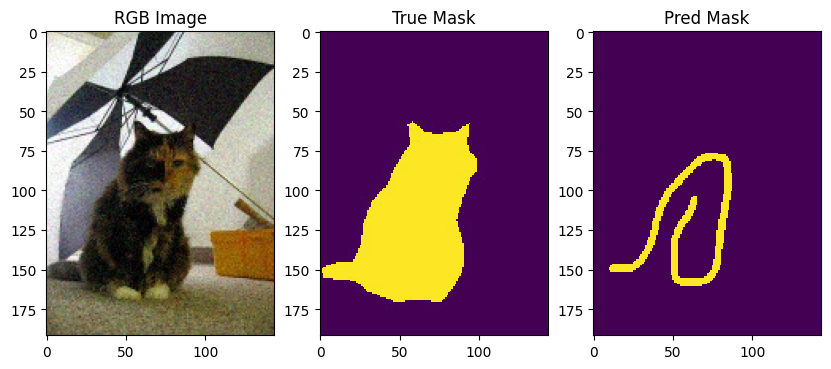

IoU score is: 0.182


In [12]:
# Run your segmentation algorithm
segmenter = ImageSegmenter(k_fg=2, k_bg=5, mode='kmeans')

mask_pred = segmenter.segment_image(sample_dd)

iou_score = compute_iou(
    sample_dd['mask_true'].astype(bool),
    mask_pred.astype(bool)
)

# Visualize your prediction
show_sample(sample_dd, mask_pred=mask_pred)
print(f'IoU score is: {iou_score:0.3f}')

### Including more features

Until now, the prediction of a pixel's class was purely based on the intensity of said pixel alone. At this point we can think of other features, that might be useful for our prediction task.
An easy feature to add is the pixels position coordinates. You should see an improvement upon adding this information to the k-means, k-NN pipeline.

Can you think what kind of prior about the segmentation this correcponds to?

### Extract patches

**Note:**</br>
The following task is optional for Exercise 2. You should not need to implement this to pass the baseline. However for Exercise 3, we will require the patch extraction function described below. Therefore you can already start implementing this function now in order to reduce the workload later on.

Other possible features could be included by considering neighborhood information around a given pixel, eg. intensities of a small patch centerd at the pixel in question.

To this end, we now aim to extract all possible patches from the image.
That is for every pixel in the image we want to extract it's p x p neighborhood.
This neighborhood can later be used as feature for prediction.

A naive implementation of this patch extraction will be way too slow!
There is a way to do this rather efficiently with the help of NumPy's roll() function.
The below image shows the principle for a 1D array.

Can you adapt & implement this idea for the case of 2D images?

What you have to do:
* Implement the function `extract_patches()`. The file `extract_patches.py` provides a starting point.
There is also a quick test, to check the correct implementation of this patch extraction.
* Afterwards you can include it in the `ImageSegmenter` to use the p x p neighborhood for feature extraction.

</br>
</br>

![](https://drive.google.com/uc?export=view&id=1tYMIkxfDTQ7tYnbfo5C6wUtfOrxRwIiO)

</br>
</br>



In [13]:
from extract_patches import check_patch_extraction, extract_patches

check_patch_extraction(extract_patches)

Dummy image of shape 4 x 5 x 1
[[ 1  2  3  4  5]
 [ 6  7  8  9 10]
 [11 12 13 14 15]
 [16 17 18 19 20]]

Patch extraction failed at location [1, 1]. 
Expected:
 [[ 1.  2.  3.]
 [ 6.  7.  8.]
 [11. 12. 13.]] 
Received:
 [[7 7 7]
 [7 7 7]
 [7 7 7]]


### Evaluate on validation data

The performance of most algorithms has a strong dependence on hyper-parameters.
In the case of the baseline implementation, these are mainly the number of FG/BG cluster.

Can you find hyper-parameters that beat the baseline?

You may do it in a trial and error fashion. Alternatively you can do an exhaustive grid search, by looping of hyper-parameters - but that's up to you!

Good luck :-)

In [ ]:
segmenter = ImageSegmenter()

iou_per_seed, proc_time_per_seed = [], []
for seed in [1, 2, 3]:
    iou, proc_time = evaluate_segmentation(segmenter, sample_dirs, seed=seed, display=True)
    iou_per_seed.append(iou)
    proc_time_per_seed.append(proc_time)

iou = sum(iou_per_seed) / len(iou_per_seed)
proc_time = sum(proc_time_per_seed) / len(proc_time_per_seed)

print(f"Mean IoU: {iou:0.3f} with average time per image of {proc_time:0.3f} s")

## Create submission


After finishing your implementation, you can run the next cell to generate your submission.
We simply copy all relevant files to the submission folder.
Download the submission folder as a zip, and upload it to the evaluation server.

The evaluation server will run the `ImageSegmenter` with it's default hyper-parameters. So remember to set your optimal hyper-parameters as defaults!

In [ ]:
out_dir = env_path / 'submission'
out_dir.mkdir(exist_ok=True)

shutil.copyfile(str(env_path / 'kmeans.py'), str(out_dir / 'kmeans.py'))
shutil.copyfile(str(env_path / 'extract_patches.py'), str(out_dir / 'extract_patches.py'))
shutil.copyfile(str(env_path / 'image_segmenter.py'), str(out_dir / 'image_segmenter.py'))

'/content/drive/MyDrive/BMIC/iacv/hs23_ex_wip/ex2/solution/submission/image_segmenter.py'